In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/Diploma

/content/gdrive/My Drive/Diploma


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from io import BytesIO
import random
import cv2

###**Utils**

In [4]:
def plot_image_depth(image, depth):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(15,15))
    axes[0].set(title='Image') 
    axes[0].imshow(image)  
    axes[1].set(title='Depth')
    axes[1].imshow(depth)  
    plt.show()
#plot_image_depth(transformed_training[1]['image'],transformed_training[1]['depth'])

In [ ]:
def segment_on_dt(img):
    import numpy
    #http://stackoverflow.com/questions/11294859/how-to-define-the-markers-for-watershed-in-opencv
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    _, img_bin = cv2.threshold(img_gray, 0, 255,cv2.THRESH_OTSU)
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN,numpy.ones((3, 3), dtype=int))
    border = cv2.dilate(img_bin, None, iterations=5)
    border = border - cv2.erode(border, None)

    dt = cv2.distanceTransform(img_bin, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(numpy.uint8)
    _, dt = cv2.threshold(dt, 180, 255, cv2.THRESH_BINARY)
    lbl, ncc = label(dt)
    lbl = lbl * (255/ncc)
    # Completing the markers now. 
    lbl[border == 255] = 255

    lbl = lbl.astype(numpy.int32)
    cv2.watershed(img, lbl)

    lbl[lbl == -1] = 0
    lbl = lbl.astype(numpy.uint8)
    result = 255 - lbl
    result[result != 255] = 0
    result = cv2.dilate(result, None)
    img[result == 255] = (0, 0, 255)
    return img

###**Dataset**

In [5]:
def loadZipToMem(zip_file):
    print('Loading dataset zip file...', end='')
    from zipfile import ZipFile
    input_zip = ZipFile(zip_file)
    data = {name: input_zip.read(name) for name in input_zip.namelist()}
    nyu2_train = list((row.split(',') for row in (data['data/nyu2_train.csv']).decode("utf-8").split('\n') if len(row) > 0))

    from sklearn.utils import shuffle
    nyu2_train = shuffle(nyu2_train, random_state=0)
    if True: nyu2_train = nyu2_train[:40]
    print('Loaded ({0}).'.format(len(nyu2_train)))
    return data, nyu2_train

In [6]:
data, nyu2_train = loadZipToMem('nyu_data.zip')

Loading dataset zip file...Loaded (40).


In [8]:
class depthDatasetMemory(Dataset):
    def __init__(self, data, nyu2_train, transform=None):
        self.data, self.nyu_dataset = data, nyu2_train
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.nyu_dataset[idx]
        image = Image.open( BytesIO(self.data[sample[0]]) )
        depth = Image.open( BytesIO(self.data[sample[1]]) )
        sample = {'image': image, 'depth': depth}
        if self.transform: 
          sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.nyu_dataset)

In [ ]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

class RandomHorizontalFlip(object):
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        if not _is_pil_image(image):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(depth)))

        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            depth = depth.transpose(Image.FLIP_LEFT_RIGHT)

        return {'image': image, 'depth': depth}

In [ ]:
class RandomChannelSwap(object):
    def __init__(self, probability):
        from itertools import permutations
        self.probability = probability
        self.indices = list(permutations(range(3), 3))

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        if not _is_pil_image(image): raise TypeError('img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth): raise TypeError('img should be PIL Image. Got {}'.format(type(depth)))
        if random.random() < self.probability:
            image = np.asarray(image)
            image = Image.fromarray(image[...,list(self.indices[random.randint(0, len(self.indices) - 1)])])
        return {'image': image, 'depth': depth}

In [ ]:
class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        
        image = self.to_tensor(image)

        depth = depth.resize((320, 240))

        if self.is_test:
            depth = self.to_tensor(depth).float() / 1000
        else:            
            depth = self.to_tensor(depth).float() * 1000
        
        # put in expected range
        depth = torch.clamp(depth, 10, 1000)

        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        if not(_is_pil_image(pic) or _is_numpy_image(pic)):
            raise TypeError(
                'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

        if isinstance(pic, np.ndarray):
            img = torch.from_numpy(pic.transpose((2, 0, 1)))

            return img.float().div(255)

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(
                torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)

        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img

def getNoTransform(is_test=False):
    return transforms.Compose([
        ToTensor(is_test=is_test)
    ])

def getDefaultTrainTransform():
    return transforms.Compose([
        RandomHorizontalFlip(),
        RandomChannelSwap(0.5),
        ToTensor()
    ])

In [9]:
transformed_training = depthDatasetMemory(data, nyu2_train, transform=None)
transformed_testing = depthDatasetMemory(data, nyu2_train, transform=None)

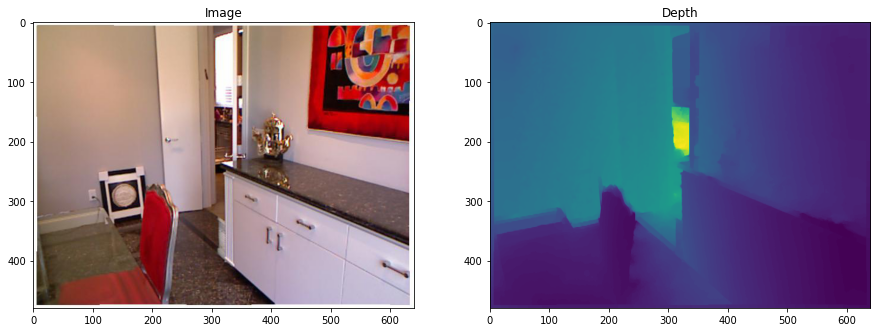

In [13]:
plot_image_depth(transformed_training[6]['image'],transformed_training[6]['depth'])

In [ ]:
transformed_training[0]

In [ ]:
transformed_testing[0]

{'depth': tensor([[[117.6471, 117.6471, 117.6471,  ...,  94.1176,  94.1176,  94.1176],
          [117.6471, 117.6471, 117.6471,  ...,  94.1176,  94.1176,  94.1176],
          [117.6471, 117.6471, 117.6471,  ...,  94.1176,  94.1176,  94.1176],
          ...,
          [ 82.3529,  82.3529,  82.3529,  ..., 105.8824, 105.8824, 105.8824],
          [ 82.3529,  82.3529,  82.3529,  ..., 105.8824, 105.8824, 105.8824],
          [ 82.3529,  82.3529,  82.3529,  ..., 105.8824, 105.8824, 105.8824]]]),
 'image': tensor([[[1.0000, 0.9451, 1.0000,  ..., 1.0000, 1.0000, 0.9922],
          [1.0000, 0.9882, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [0.9804, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 0.9804],
          ...,
          [0.9961, 1.0000, 1.0000,  ..., 0.9882, 0.9843, 0.9882],
          [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9882, 0.9725],
          [1.0000, 1.0000, 1.0000,  ..., 0.9686, 0.9882, 0.9725]],
 
         [[0.9961, 0.9412, 0.9961,  ..., 0.9843, 0.9843, 0.9686],
          [0.996

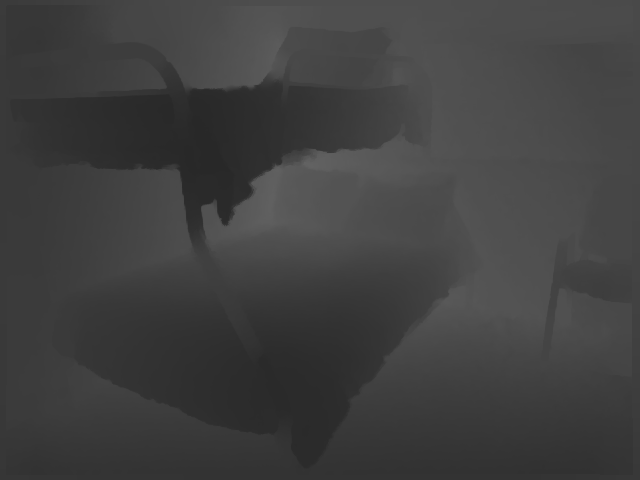

In [ ]:
transformed_training[1]['depth']

In [ ]:
def segment_watershed(img):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh=cv2.threshold(gray, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    '''
    foreground region
    '''
    fg=cv2.erode(thresh,None, iterations=2)
    '''
    background region
    '''
    bg=cv2.dilate(thresh, None,iterations=3)
    ret, bg=cv2.threshold(bg,1,128,1)
    '''
    add both fg and bg
    '''
    marker=cv2.add(fg, bg)
    '''
    convert into 32SC1
    '''
    marker32=np.int32(marker)
    '''
    apply watershed
    '''
    cv2.watershed(img, marker32)
    m=cv2.convertScaleAbs(marker32)
    '''
    threshold it properly to get the mask and perform bitwise_and with the input image
    '''
    ret, thresh=cv2.threshold(m,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    result=cv2.bitwise_and(img, img,mask=thresh)
    return result

In [ ]:
segment_on_dt(transformed_training[1]['image'])

TypeError: ignored

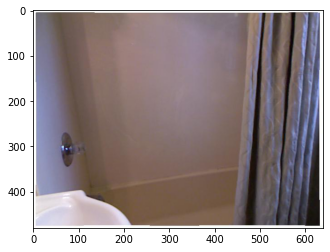

In [ ]:
import matplotlib.pyplot as plt

plt.

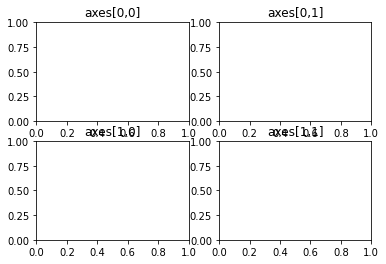

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 2, ncols =2 )

axes[0,0].set(title='axes[0,0]')
axes[0,1].set(title='axes[0,1]')
axes[1,0].set(title='axes[1,0]')
axes[1,1].set(title='axes[1,1]')

for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
    
plt.show()

In [ ]:
def plot_image_depth(image, depth):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(15,15))
    axes[0].set(title='Image') 
    axes[0].imshow(image)  
    axes[1].set(title='Depth')
    axes[1].imshow(depth)  
    plt.show()
#plot_image_depth(transformed_training[1]['image'],transformed_training[1]['depth'])